In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
import gc

# Process TSV files


data_dir = "/Users/zoey/Documents/2026spring/"
tsv_files = list(Path(data_dir).rglob("*.tsv"))

print(f"Found {len(tsv_files)} TSV files")

def process_file(file_path: Path) -> pd.DataFrame:
    """Read and process a single TSV file"""
    # Read TSV file
    data = pd.read_csv(file_path, sep='\t', comment='#')
    
    # Get file UUID from parent directory name
    file_uuid = file_path.parent.name
    mask = (
        data['gene_name'].notna() & 
        (~data['gene_name'].astype(str).str.startswith('N_'))
    )
    data_clean = data.loc[mask, ['gene_name', 'unstranded']].copy()
    
    # Remove duplicates by summing counts
    data_clean = data_clean.groupby('gene_name', as_index=False)['unstranded'].sum()
    
    # Rename column to UUID
    data_clean.rename(columns={'unstranded': file_uuid}, inplace=True)
    
    return data_clean

# Process all files
print("\nProcessing first file...")
expression_matrix = process_file(tsv_files[0])
print(f"First file: {len(expression_matrix)} unique genes")

print("\nProcessing remaining files...")
for i, file_path in enumerate(tsv_files[1:], start=2):
    if i % 50 == 0:
        print(f"Processing file {i}/{len(tsv_files)}")
        gc.collect()
    
    file_data = process_file(file_path)
    expression_matrix = expression_matrix.merge(file_data, on='gene_name', how='left')

print(f"\nRaw counts matrix: {len(expression_matrix)} genes x {expression_matrix.shape[1]-1} samples")
print(f"Matrix size: {expression_matrix.memory_usage(deep=True).sum() / 1024**2:.2f} MB")


# Prepare count matrix
print("\n=== PREPARING MATRIX ===")

# Set gene_name as index
counts_matrix = expression_matrix.set_index('gene_name')

# Free memory
del expression_matrix
gc.collect()

# Convert to numeric and round to integers
counts_matrix = counts_matrix.astype(float).round().astype(int)

print(f"Count matrix: {counts_matrix.shape[0]} genes x {counts_matrix.shape[1]} samples")
print(f"Matrix size: {counts_matrix.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Filter low-count genes

print("\n=== FILTERING LOW-COUNT GENES ===")

# Keep genes with at least 10 reads in at least 10 samples
keep = (counts_matrix >= 10).sum(axis=1) >= 10
counts_filtered = counts_matrix[keep]

print(f"After filtering: {len(counts_filtered)} genes kept out of {len(counts_matrix)}")

# Free memory
del counts_matrix
gc.collect()

Found 884 TSV files

Processing first file...
First file: 59427 unique genes

Processing remaining files...
Processing file 50/884
Processing file 100/884
Processing file 150/884
Processing file 200/884
Processing file 250/884
Processing file 300/884
Processing file 350/884
Processing file 400/884
Processing file 450/884
Processing file 500/884
Processing file 550/884
Processing file 600/884
Processing file 650/884
Processing file 700/884
Processing file 750/884
Processing file 800/884
Processing file 850/884

Raw counts matrix: 59427 genes x 884 samples
Matrix size: 404.47 MB

=== PREPARING MATRIX ===
Count matrix: 59427 genes x 884 samples
Matrix size: 404.47 MB

=== FILTERING LOW-COUNT GENES ===
After filtering: 36538 genes kept out of 59427


0

In [ ]:
# ============================================================
# STEP 4: VST Normalization using PyDESeq2
# ============================================================

print("\n=== VST NORMALIZATION ===")


# Log2(CPM + 1) normalization
# Calculate library sizes
lib_sizes = counts_filtered.sum(axis=0)

# Calculate CPM (Counts Per Million)
cpm = counts_filtered.div(lib_sizes / 1e6, axis=1)

# Log2 transform
vst_counts = np.log2(cpm + 1)

# Transpose so samples are rows
vst_counts = vst_counts.T

print(f"Log2(CPM+1) normalized: {vst_counts.shape[0]} samples x {vst_counts.shape[1]} genes")

# Free memory
del counts_filtered
gc.collect()

# Map UUIDs to TCGA Patient Barcodes

print("\n=== MAPPING UUIDs TO PATIENT IDs ===")

# Load the manifest file (adjust path as needed)
manifest = pd.read_csv("gdc_manifest.txt", sep="\t")

# Create UUID to filename mapping from manifest
uuid_map = dict(zip(manifest['id'], manifest['filename']))

# Load clinical/sample sheet data if available
mapping_successful = False

try:
    sample_sheet = pd.read_csv("gdc_sample_sheet.tsv", sep="\t")
    
    # Create UUID to TCGA barcode mapping
    uuid_to_barcode = dict(zip(sample_sheet['File ID'], sample_sheet['Sample ID']))
    
    # Map the index
    patient_ids = [uuid_to_barcode.get(uuid, uuid) for uuid in vst_counts.index]
    
    # Count successfully mapped samples
    mapped_count = sum(1 for uuid, pid in zip(vst_counts.index, patient_ids) if pid != uuid)
    
    vst_counts.index = patient_ids
    vst_counts.index.name = 'patient_id'
    
    mapping_successful = True
    print(f"✓ Mapped {mapped_count}/{len(vst_counts.index)} UUIDs to patient barcodes")
    
    # Show unmapped samples if any
    unmapped = [uuid for uuid in vst_counts.index if uuid in vst_counts.index and not uuid.startswith('TCGA-')]
    if unmapped:
        print(f"⚠ Warning: {len(unmapped)} samples could not be mapped")
    
except FileNotFoundError:
    print("⚠ Sample sheet not found. Using UUIDs as identifiers.")
    print("To get patient IDs, download the sample sheet from GDC portal.")
    vst_counts.index.name = 'sample_uuid'

except Exception as e:
    print(f"⚠ Error during mapping: {e}")
    print("Using UUIDs as identifiers.")
    vst_counts.index.name = 'sample_uuid'


print("\n=== SAVING OUTPUT ===")

# Save to CSV (samples as rows, genes as columns)
vst_counts.to_csv("tcga-brca-vst-normalized-counts.csv")

print("✓ VST-normalized counts saved: tcga-brca-vst-normalized-counts.csv")


print("\n=== FINAL OUTPUT ===")
print(f"Dimensions: {vst_counts.shape[0]} samples x {vst_counts.shape[1]} genes")

# Updated message based on whether mapping succeeded
if mapping_successful:
    print("\nFirst 5 patient IDs:")
else:
    print("\nFirst 5 sample IDs (UUIDs):")
print(vst_counts.index[:5].tolist())

print("\nFirst 5 gene names:")
print(vst_counts.columns[:5].tolist())

print("\nData preview:")
print(vst_counts.iloc[:5, :6])

print("\nValue range:")
print(f"Min: {vst_counts.values.min():.3f}")
print(f"Max: {vst_counts.values.max():.3f}")
print(f"Mean: {vst_counts.values.mean():.3f}")

print("\n=== PROCESSING COMPLETE ===")
if mapping_successful:
    print("✓ Sample names mapped to TCGA patient barcodes")
else:
    print("⚠ Sample names are file UUIDs from folder names")
    print("Download gdc_sample_sheet.tsv from GDC portal to map to patient IDs")

print("\nTo load in Python:")
print('df = pd.read_csv("tcga-brca-vst-normalized-counts.csv", index_col=0)')


=== VST NORMALIZATION ===
PyDESeq2 not installed. Using alternative normalization...


NameError: name 'counts_filtered' is not defined

In [1]:
import pandas as pd 

df = pd.read_csv("BRCA-data.tsv")
print(df.columns)

Index(['\t5S_rRNA\t5_8S_rRNA\t7SK\tA1BG\tA1BG-AS1\tA1CF\tA2M\tA2M-AS1\tA2ML1\tA2ML1-AS1\tA2ML1-AS2\tA2MP1\tA3GALT2\tA4GALT\tA4GNT\tAA06\tAAAS\tAACS\tAACSP1\tAADAC\tAADACL2\tAADACL2-AS1\tAADACL3\tAADACL4\tAADACP1\tAADAT\tAAGAB\tAAK1\tAAMDC\tAAMP\tAANAT\tAAR2\tAARD\tAARS1\tAARS1P1\tAARS2\tAARSD1\tAARSD1P1\tAASDH\tAASDHPPT\tAASS\tAATBC\tAATF\tAATK\tABALON\tABAT\tABBA01000933.1\tABBA01000935.2\tABBA01006766.1\tABBA01045074.1\tABBA01045074.2\tABCA1\tABCA10\tABCA11P\tABCA12\tABCA13\tABCA17P\tABCA2\tABCA3\tABCA4\tABCA5\tABCA6\tABCA7\tABCA8\tABCA9\tABCA9-AS1\tABCB1\tABCB10\tABCB10P1\tABCB10P3\tABCB10P4\tABCB11\tABCB4\tABCB5\tABCB6\tABCB7\tABCB8\tABCB9\tABCC1\tABCC10\tABCC11\tABCC12\tABCC13\tABCC2\tABCC3\tABCC4\tABCC5\tABCC5-AS1\tABCC6\tABCC6P1\tABCC6P2\tABCC8\tABCC9\tABCD1\tABCD1P2\tABCD1P3\tABCD1P4\tABCD1P5\tABCD2\tABCD3\tABCD4\tABCE1\tABCF1\tABCF2\tABCF2-H2BE1\tABCF2P1\tABCF2P2\tABCF3\tABCG1\tABCG2\tABCG4\tABCG5\tABCG8\tABHD1\tABHD10\tABHD11\tABHD11-AS1\tABHD12\tABHD12B\tABHD13\tABHD14A\tABH

In [4]:
input_file = "BRCA-data.tsv"
output_file = "BRCA-data-top1000.tsv"
n_genes = 1000

# Load the data
print(f"Loading data from {input_file}...")
df = pd.read_csv(input_file, sep='\t')
print(f"Original shape: {df.shape} (rows × columns)")

# Identify label column (last column) and gene columns (all others)
id_col = df.columns[0]
label_column = df.columns[-1]
gene_columns = df.columns[1:-1].tolist()

print(f"\nLabel column: '{label_column}'")
print(f"Number of gene columns: {len(gene_columns)}")

# Calculate variance for each gene
print(f"\nCalculating variance for each gene...")
variances = df[gene_columns].var()

# Select top N most variant genes
print(f"Selecting top {n_genes} most variant genes...")
top_genes = variances.nlargest(n_genes).index.tolist()

# Create reduced dataset with selected genes + label
columns_to_keep = [id_col] + top_genes + [label_column]
df_reduced = df[columns_to_keep]

print(f"\nReduced shape: {df_reduced.shape} (rows × columns)")
print(f"Kept: {len(top_genes)} genes + 1 label = {len(columns_to_keep)} columns")

# Display variance statistics
selected_variances = variances[top_genes]
print(f"\nVariance statistics for selected genes:")
print(f"  Min:    {selected_variances.min():.6f}")
print(f"  Max:    {selected_variances.max():.6f}")
print(f"  Mean:   {selected_variances.mean():.6f}")
print(f"  Median: {selected_variances.median():.6f}")

# Save the reduced dataset
print(f"\nSaving to {output_file}...")
df_reduced.to_csv(output_file, sep='\t', index=False)

print(f"\n✓ Done! Reduced dataset saved to {output_file}")
print(f"  Original: {df.shape[0]} samples × {df.shape[1]} columns")
print(f"  Reduced:  {df_reduced.shape[0]} samples × {df_reduced.shape[1]} columns")


Loading data from BRCA-data.tsv...
Original shape: (991, 59429) (rows × columns)

Label column: 'Subtype'
Number of gene columns: 59427

Calculating variance for each gene...
Selecting top 1000 most variant genes...

Reduced shape: (991, 1002) (rows × columns)
Kept: 1000 genes + 1 label = 1002 columns

Variance statistics for selected genes:
  Min:    1.467303
  Max:    16.990120
  Mean:   2.790372
  Median: 2.189190

Saving to BRCA-data-top1000.tsv...

✓ Done! Reduced dataset saved to BRCA-data-top1000.tsv
  Original: 991 samples × 59429 columns
  Reduced:  991 samples × 1002 columns


In [5]:
import pandas as pd
import numpy as np

# Configuration
input_file = "BRCA-data-top1000.tsv"  # Your 1000-gene dataset
output_file = "BRCA-data-one-per-patient.csv"
random_seed = 42  # Set seed for reproducibility (optional, remove for true randomness)

# Load the data
print(f"Loading data from {input_file}...")
df = pd.read_csv(input_file, sep='\t')
print(f"Original shape: {df.shape} (rows × columns)")

# Get the sample ID column (first column)
sample_id_column = df.columns[0]
print(f"\nSample ID column: '{sample_id_column}'")
print(f"Sample examples:")
for sample in df[sample_id_column].head(5):
    print(f"  {sample}")

# Extract patient IDs (everything before the last dash)
print(f"\nExtracting patient IDs...")
df['patient_id'] = df[sample_id_column].astype(str).str.rsplit('-', n=1).str[0]

# Show extraction examples
print(f"\nExtraction examples:")
for i in range(min(5, len(df))):
    sample = df[sample_id_column].iloc[i]
    patient = df['patient_id'].iloc[i]
    print(f"  {sample} → Patient: {patient}")

# Count samples per patient
samples_per_patient = df['patient_id'].value_counts()
print(f"\n=== Statistics ===")
print(f"Total samples: {len(df)}")
print(f"Unique patients: {len(samples_per_patient)}")
print(f"Patients with multiple samples: {(samples_per_patient > 1).sum()}")

# Show distribution of samples per patient
print(f"\nSamples per patient distribution:")
distribution = samples_per_patient.value_counts().sort_index()
for n_samples, n_patients in distribution.items():
    print(f"  {n_samples} sample(s): {n_patients} patients")

# Show examples of patients with multiple samples
multi_sample_patients = samples_per_patient[samples_per_patient > 1].head(5)
if len(multi_sample_patients) > 0:
    print(f"\nExamples of patients with multiple samples:")
    for patient, count in multi_sample_patients.items():
        patient_samples = df[df['patient_id'] == patient][sample_id_column].tolist()
        print(f"  Patient {patient}: {count} samples")
        for sample in patient_samples:
            print(f"    - {sample}")

# Randomly select one sample per patient
print(f"\n=== Randomly selecting one sample per patient ===")
if random_seed is not None:
    print(f"Using random seed: {random_seed} (for reproducibility)")
else:
    print(f"Using true randomness (no seed)")

# Group by patient and randomly sample one from each group
df_final = df.groupby('patient_id', group_keys=False).apply(
    lambda x: x.sample(n=1, random_state=random_seed)
).reset_index(drop=True)

# Show some examples of selected samples
print(f"\nExamples of randomly selected samples:")
for patient in df_final['patient_id'].head(5):
    selected_sample = df_final[df_final['patient_id'] == patient][sample_id_column].iloc[0]
    all_samples = df[df['patient_id'] == patient][sample_id_column].tolist()
    if len(all_samples) > 1:
        print(f"  Patient {patient}: selected {selected_sample} from {all_samples}")
    else:
        print(f"  Patient {patient}: only sample {selected_sample}")

# Remove the temporary patient_id column (keep sample_id column)
df_final = df_final.drop('patient_id', axis=1)

print(f"\nAfter random selection: {df_final.shape} (rows × columns)")
print(f"Removed {len(df) - len(df_final)} samples")

# Verify we have one sample per patient
print(f"\n=== Verification ===")
df_final['patient_id_check'] = df_final[sample_id_column].astype(str).str.rsplit('-', n=1).str[0]
unique_patients = df_final['patient_id_check'].nunique()
df_final = df_final.drop('patient_id_check', axis=1)
print(f"Unique patients in final dataset: {unique_patients}")
print(f"Total samples in final dataset: {len(df_final)}")
print(f"✓ Verification: {'PASSED' if unique_patients == len(df_final) else 'FAILED'}")

# Save the final dataset as CSV
print(f"\nSaving to {output_file}...")
df_final.to_csv(output_file, index=False)

print(f"\n✓ Done! Final dataset saved to {output_file}")
print(f"\n=== SUMMARY ===")
print(f"Input:  {len(df)} samples × {df.shape[1]-1} columns")
print(f"Output: {len(df_final)} samples × {df_final.shape[1]} columns")
print(f"Reduction: {len(df) - len(df_final)} duplicate patient samples removed")

Loading data from BRCA-data-top1000.tsv...
Original shape: (991, 1002) (rows × columns)

Sample ID column: 'Unnamed: 0'
Sample examples:
  TCGA-AQ-A0Y5-01
  TCGA-C8-A274-01
  TCGA-BH-A0BD-01
  TCGA-B6-A1KC-01
  TCGA-AO-A0J5-01

Extracting patient IDs...

Extraction examples:
  TCGA-AQ-A0Y5-01 → Patient: TCGA-AQ-A0Y5
  TCGA-C8-A274-01 → Patient: TCGA-C8-A274
  TCGA-BH-A0BD-01 → Patient: TCGA-BH-A0BD
  TCGA-B6-A1KC-01 → Patient: TCGA-B6-A1KC
  TCGA-AO-A0J5-01 → Patient: TCGA-AO-A0J5

=== Statistics ===
Total samples: 991
Unique patients: 981
Patients with multiple samples: 10

Samples per patient distribution:
  1 sample(s): 971 patients
  2 sample(s): 10 patients

Examples of patients with multiple samples:
  Patient TCGA-A7-A13E: 2 samples
    - TCGA-A7-A13E-01
    - TCGA-A7-A13E-01
  Patient TCGA-A7-A13G: 2 samples
    - TCGA-A7-A13G-01
    - TCGA-A7-A13G-01
  Patient TCGA-A7-A13D: 2 samples
    - TCGA-A7-A13D-01
    - TCGA-A7-A13D-01
  Patient TCGA-A7-A26J: 2 samples
    - TCGA-A7-A2

/var/folders/xs/tc25t1516xgcsh4gzrw6vd180000gn/T/ipykernel_79486/1939870937.py:63: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_final = df.groupby('patient_id', group_keys=False).apply(



Examples of randomly selected samples:
  Patient TCGA-3C-AAAU: only sample TCGA-3C-AAAU-01
  Patient TCGA-3C-AALI: only sample TCGA-3C-AALI-01
  Patient TCGA-3C-AALJ: only sample TCGA-3C-AALJ-01
  Patient TCGA-3C-AALK: only sample TCGA-3C-AALK-01
  Patient TCGA-4H-AAAK: only sample TCGA-4H-AAAK-01

After random selection: (981, 1002) (rows × columns)
Removed 10 samples

=== Verification ===
Unique patients in final dataset: 981
Total samples in final dataset: 981
✓ Verification: PASSED

Saving to BRCA-data-one-per-patient.csv...

✓ Done! Final dataset saved to BRCA-data-one-per-patient.csv

=== SUMMARY ===
Input:  991 samples × 1002 columns
Output: 981 samples × 1002 columns
Reduction: 10 duplicate patient samples removed


In [7]:
df_final = df_final.rename(columns={df_final.columns[0]: 'sample_id'})
df_final.to_csv(output_file, index=False)

In [8]:
print(df_final.columns[-1])

Subtype


In [9]:
input_file = "BRCA-data-one-per-patient.csv"  # Your input file
output_file = "BRCA-data-with-integer-labels.csv"  # Output file

# Load the data
print(f"Loading data from {input_file}...")
df_final = pd.read_csv(input_file)
print(f"Shape: {df_final.shape} (rows × columns)")

# Get the last column (label column)
label_column = df_final.columns[-1]
print(f"\nLabel column: '{label_column}'")

# Display original labels
print(f"\nOriginal labels (strings):")
original_labels = df_final[label_column].value_counts().sort_index()
for label, count in original_labels.items():
    print(f"  '{label}': {count} samples")

# Create mapping from string labels to integers (starting from 0)
unique_labels = sorted(df_final[label_column].unique())
label_mapping = {label: idx for idx, label in enumerate(unique_labels)}

print(f"\n=== Label Mapping ===")
for label, idx in label_mapping.items():
    print(f"  '{label}' → {idx}")

# Apply the mapping
df_final[label_column] = df_final[label_column].map(label_mapping)

# Display new labels
print(f"\nNew labels (integers):")
new_labels = df_final[label_column].value_counts().sort_index()
for label, count in new_labels.items():
    print(f"  {label}: {count} samples")

# Save the result
print(f"\nSaving to {output_file}...")
df_final.to_csv(output_file, index=False)

print(f"\n✓ Done! Dataset with integer labels saved to {output_file}")
print(f"\nSummary:")
print(f"  Total samples: {len(df_final)}")
print(f"  Number of cancer subtypes: {len(label_mapping)}")
print(f"  Labels converted: strings → integers (0 to {len(label_mapping)-1})")

Loading data from BRCA-data-one-per-patient.csv...
Shape: (981, 1002) (rows × columns)

Label column: 'Subtype'

Original labels (strings):
  'BRCA_Basal': 171 samples
  'BRCA_Her2': 78 samples
  'BRCA_LumA': 499 samples
  'BRCA_LumB': 197 samples
  'BRCA_Normal': 36 samples

=== Label Mapping ===
  'BRCA_Basal' → 0
  'BRCA_Her2' → 1
  'BRCA_LumA' → 2
  'BRCA_LumB' → 3
  'BRCA_Normal' → 4

New labels (integers):
  0: 171 samples
  1: 78 samples
  2: 499 samples
  3: 197 samples
  4: 36 samples

Saving to BRCA-data-with-integer-labels.csv...

✓ Done! Dataset with integer labels saved to BRCA-data-with-integer-labels.csv

Summary:
  Total samples: 981
  Number of cancer subtypes: 5
  Labels converted: strings → integers (0 to 4)


In [10]:
import csv 

features = list(df_final.columns) 
file_path = "/Users/zoey/Documents/2026spring/header.csv" 

with open(file_path, 'w', newline='') as file:
    csv_writer = csv.writer(file)
    csv_writer.writerow(features)

print(f"features written to {file_path}")

features written to /Users/zoey/Documents/2026spring/header.csv


In [12]:
df1 = pd.read_csv("/Users/zoey/Documents/2026spring/site_output/site-1.csv") 
print(df1.iloc[:, -1].value_counts().sort_index())
df2 = pd.read_csv("/Users/zoey/Documents/2026spring/site_output/site-2.csv")
print(df2.iloc[:, -1].value_counts().sort_index())


Subtype
0     93
1     35
2    242
3    102
4     18
Name: count, dtype: int64
0
0     77
1     43
2    257
3     95
4     18
Name: count, dtype: int64


In [14]:
import pandas as pd 

df1 = pd.read_csv("/Users/zoey/Downloads/site-1_feature_importance_FINAL_SUMMARY.csv")
df2 = pd.read_csv("/Users/zoey/Downloads/site-2_feature_importance_FINAL_SUMMARY.csv")

print(df1.columns)

Index(['feature_name', 'feature_index', 'avg_gain_importance',
       'std_gain_importance', 'max_gain_importance', 'avg_weight_importance',
       'avg_cover_importance'],
      dtype='object')


1      CDC20                          103.2899        12.4657        
2      MLPH                           56.4238         27.0940        
3      XBP1                           38.1666         19.9899        
4      BIRC5                          34.3551         3.8354         
5      MYB                            23.1404         0.8326         
6      ERBB2                          19.9199         6.7949         
7      AL356311.1                     19.8286         1.3978         
8      ESR1                           15.3264         17.0570        
9      ELN                            13.4106         7.8165         
10     TMEM150C                       13.3998         0.5690         


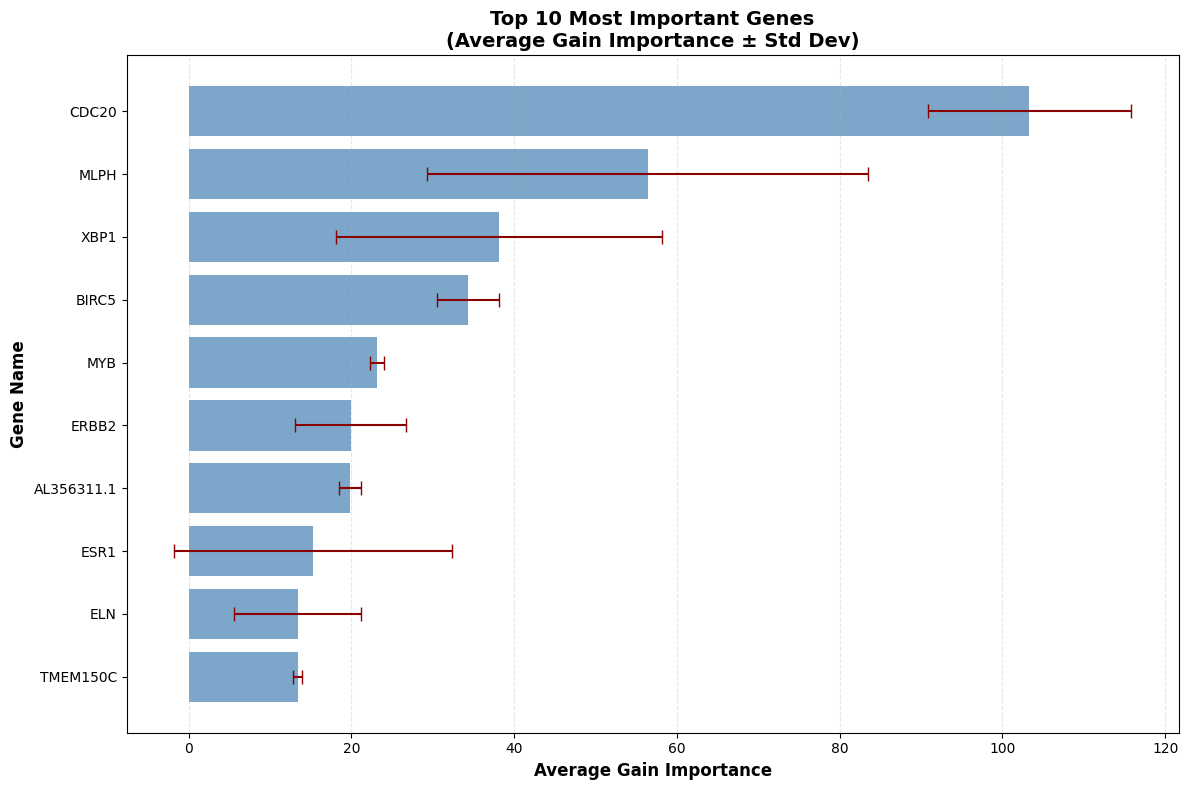

In [ ]:
import matplotlib.pyplot as plt 

top_gene_1 = df1.nlargest(10, "avg_gain_importance")
top_gene_2 = df2.nlargest(10, "avg_gain_importance")

for idx, row in enumerate(top_gene_1.iterrows(), 1):
    gene = row[1]['feature_name']
    avg = row[1]['avg_gain_importance']
    std = row[1]['std_gain_importance']
    print(f"{idx:<6} {gene:<30} {avg:<15.4f} {std:<15.4f}")

print("=" * 80)

# Create bar plot with error bars
fig, ax = plt.subplots(figsize=(12, 8))

x = np.arange(len(top_gene_1))
gene_names = top_gene_1['feature_name'].tolist()
avg_gains = top_gene_1['avg_gain_importance'].tolist()
std_gains = top_gene_1['std_gain_importance'].tolist()

# Bar plot with error bars
bars = ax.barh(x, avg_gains, xerr=std_gains, color='steelblue', 
               alpha=0.7, capsize=5, ecolor='darkred')

# Customize
ax.set_yticks(x)
ax.set_yticklabels(gene_names)
ax.invert_yaxis()  # Highest at top
ax.set_xlabel('Average Gain Importance', fontsize=12, fontweight='bold')
ax.set_ylabel('Gene Name', fontsize=12, fontweight='bold')
ax.set_title('Top 10 Most Important Genes\n(Average Gain Importance ± Std Dev)', 
             fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3, linestyle='--')

plt.tight_layout()

# Save plot

plt.savefig("box_plot1.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
for idx, row in enumerate(top_gene_2.iterrows(), 1):
    gene = row[1]['feature_name']
    avg = row[1]['avg_gain_importance']
    std = row[1]['std_gain_importance']
    print(f"{idx:<6} {gene:<30} {avg:<15.4f} {std:<15.4f}")

print("=" * 80)

# Create bar plot with error bars
fig, ax = plt.subplots(figsize=(12, 8))

x = np.arange(len(top_gene_2))
gene_names = top_gene_2['feature_name'].tolist()
avg_gains = top_gene_2['avg_gain_importance'].tolist()
std_gains = top_gene_2['std_gain_importance'].tolist()

# Bar plot with error bars
bars = ax.barh(x, avg_gains, xerr=std_gains, color='steelblue', 
               alpha=0.7, capsize=5, ecolor='darkred')

# Customize
ax.set_yticks(x)
ax.set_yticklabels(gene_names)
ax.invert_yaxis()  # Highest at top
ax.set_xlabel('Average Gain Importance', fontsize=12, fontweight='bold')
ax.set_ylabel('Gene Name', fontsize=12, fontweight='bold')
ax.set_title('Top 10 Most Important Genes\n(Average Gain Importance ± Std Dev)', 
             fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3, linestyle='--')

plt.tight_layout()

# Save plot

plt.savefig("box_plot2.png", dpi=300, bbox_inches='tight')
plt.show()